# Polynomial Regression: OLS, Ridge, and LASSO — GD vs SGD
Seed = 3155, degree = 10, N = 1000, noise ~ N(0,1).  
Learning rates: **0.20 × eta_safe** for all optimizers to make comparisons apples-to-apples.
Convergence y-axis uses plain MSE (not penalized).

In [23]:
# Imports and constants
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from mlmods.data_utils import make_dataset, polynomial_features, runge
from mlmods.metrics_utils import mse, r2_score, max_abs_diff, eta_safe_from_hessian, train_mse_over_traj
from mlmods.grads import ols_grad_full_builder, ridge_grad_full_builder, lasso_grad_full_builder
from mlmods.grads import ols_grad_minibatch, ridge_grad_minibatch, lasso_grad_minibatch
from mlmods.trainers import train_full_batch_family, train_sgd_family
from mlmods.closed_form import ols_closed_form, ridge_closed_form
from mlmods.plotting_utils import plot_convergence, plot_final_coeffs_with_cf

# We'll apply preprocessing per cell:
from mlmods.data_utils import standardize_train_test as standardize, add_intercept

# Global config (keep everything consistent)
SEED   = 3155
N      = 1000
DEGREE = 10
NOISE  = 1.0
LAM    = 1e-2        # λ used for Ridge and LASSO
ITERS  = 200
BATCH  = 50
LR_FULL = 0.20       # scale * eta_safe for full-batch
LR_SGD  = 0.20       # scale * eta_safe for SGD

np.random.seed(SEED)

# Raw split (no intercept, no scaling done).
# We ignore the preprocessed pair from make_dataset; we will transform per method.
(X_tr_raw, X_te_raw, y_tr, y_te), _ = make_dataset(N, DEGREE, seed=SEED, noise_std=NOISE)

## OLS: GD vs SGD 


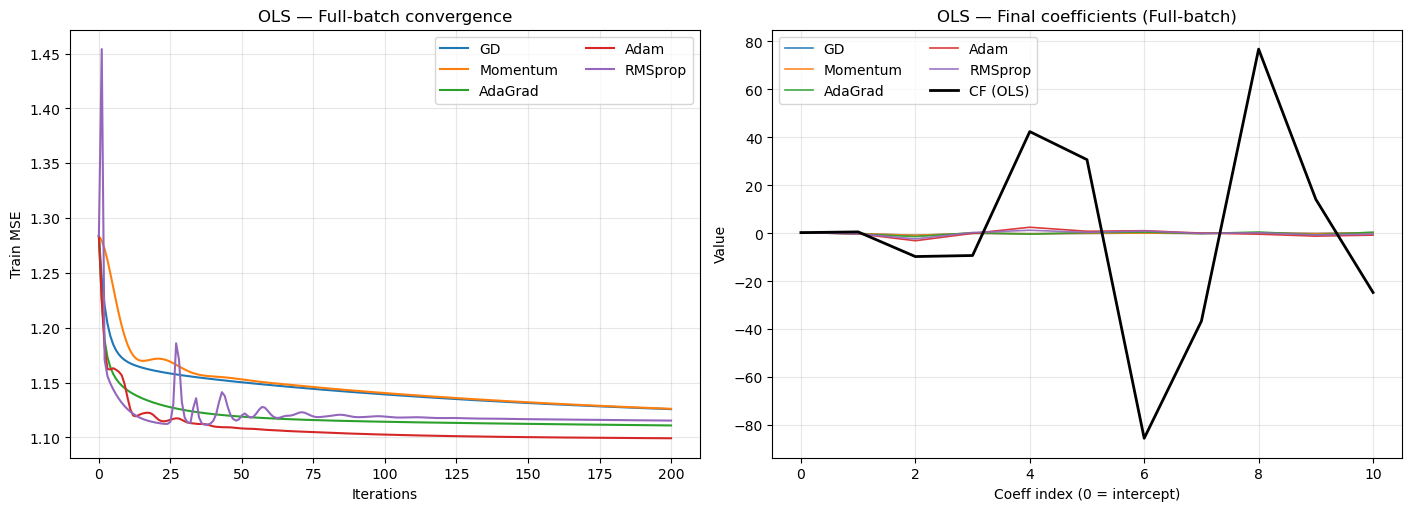

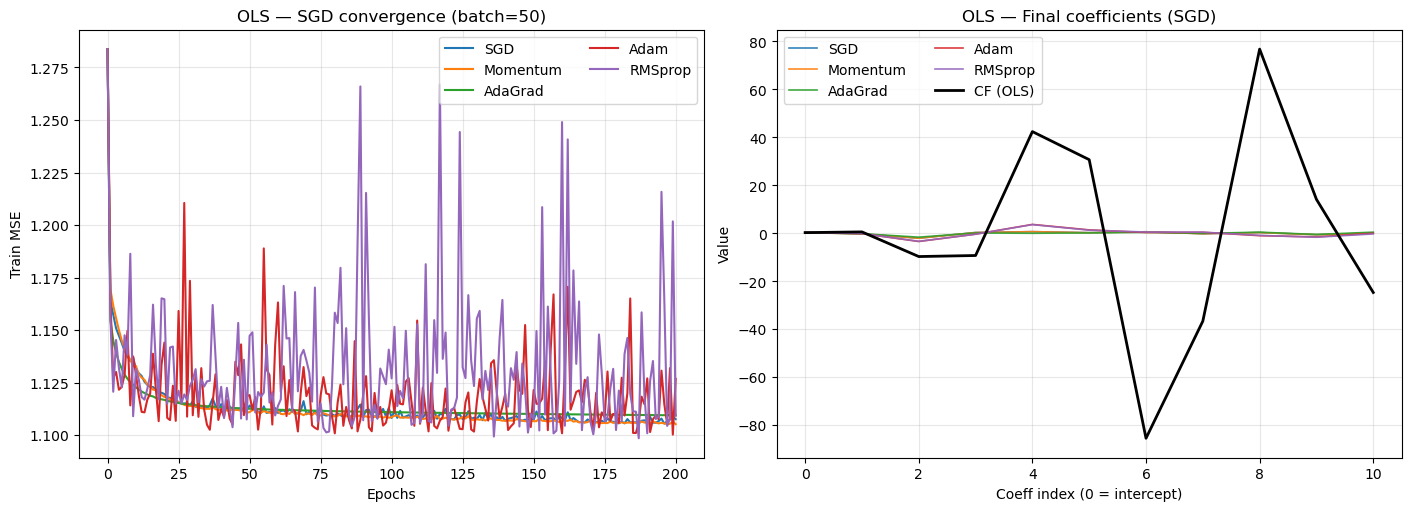

In [24]:
# ===== OLS (center-only features) =============================================

# Center features using TRAIN stats; leave y untouched; THEN add intercept
Xc_tr_t, Xc_te_t, mu_c, sd_c = standardize(X_tr_raw, X_te_raw, mode="center")
Xc_tr = add_intercept(Xc_tr_t)
Xc_te = add_intercept(Xc_te_t)

# Sanity checks
assert np.allclose(Xc_tr[:,0], 1.0) and np.allclose(Xc_te[:,0], 1.0), "Intercept must be 1s."
assert np.allclose(Xc_tr[:,1:].mean(axis=0), 0.0, atol=1e-10), "Centered features should have ~0 train mean."

# Safe step size from Hessian on THIS design
eta_ols = eta_safe_from_hessian(Xc_tr, lam=0.0)

# OLS gradients (full + minibatch) on centered design
ols_full = ols_grad_full_builder(Xc_tr, y_tr)
def ols_mb(theta, Xb, yb):
    return ols_grad_minibatch(theta, Xb, yb)

# Learning rates
lr_fb  = LR_FULL * eta_ols
lr_sgd = LR_SGD  * eta_ols

# Train families
fb_ols = train_full_batch_family(ols_full, Xc_tr, y_tr, lr=lr_fb,  iters=ITERS)
mb_ols = train_sgd_family(ols_mb, Xc_tr, y_tr, lr=lr_sgd, epochs=ITERS, batch_size=BATCH, seed=SEED)

# Closed form (same centered design with manual intercept)
theta_cf_ols = ols_closed_form(Xc_tr, y_tr)

# Convergence (MSE) and final coefficients
conv_fb_ols = {k: train_mse_over_traj(Xc_tr, y_tr, traj, mse) for k, (_, traj) in fb_ols.items()}
conv_mb_ols = {k: train_mse_over_traj(Xc_tr, y_tr, traj, mse) for k, (_, traj) in mb_ols.items()}

fig, axes = plt.subplots(1, 2, figsize=(14,5), constrained_layout=True)
plot_convergence(axes[0], conv_fb_ols, "OLS — Full-batch convergence", "Iterations")
plot_final_coeffs_with_cf(axes[1], fb_ols, theta_cf_ols, "OLS — Final coefficients (Full-batch)", cf_label="CF (OLS)")
plt.savefig("OlsGd.pdf")
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14,5), constrained_layout=True)
plot_convergence(axes[0], conv_mb_ols, f"OLS — SGD convergence (batch={BATCH})", "Epochs")
plot_final_coeffs_with_cf(axes[1], mb_ols, theta_cf_ols, "OLS — Final coefficients (SGD)", cf_label="CF (OLS)")
plt.savefig("OlsSgd.pdf")
plt.show()

## Ridge: GD vs SGD
We regularize all non-intercept weights with λ = 1e-2. The closed-form reference is unpenalized on the intercept.

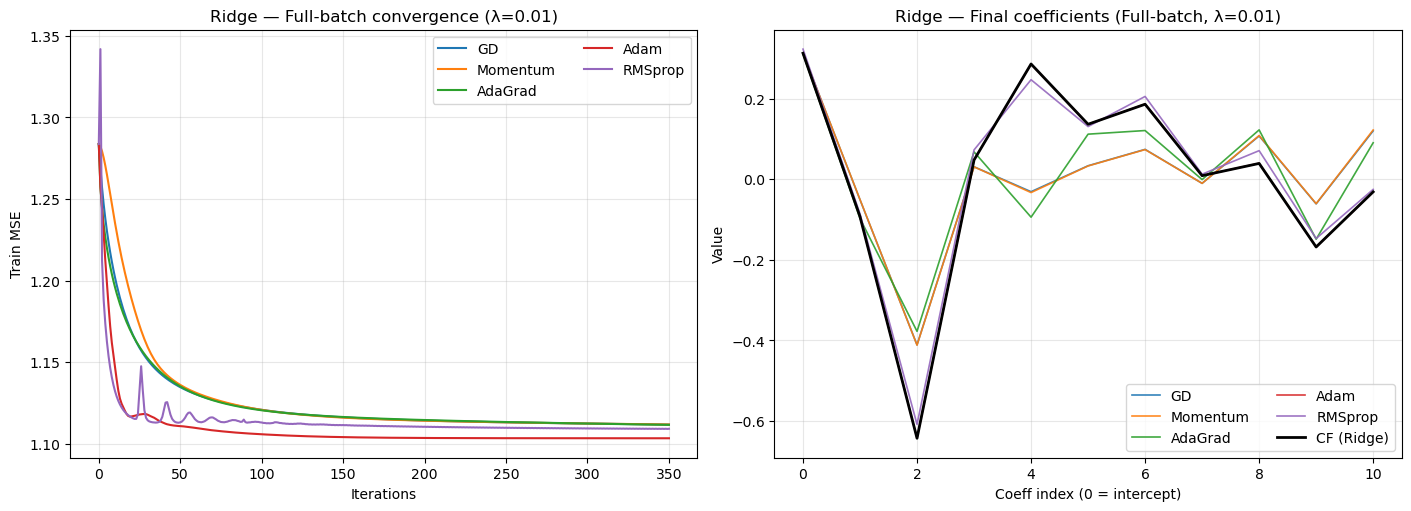

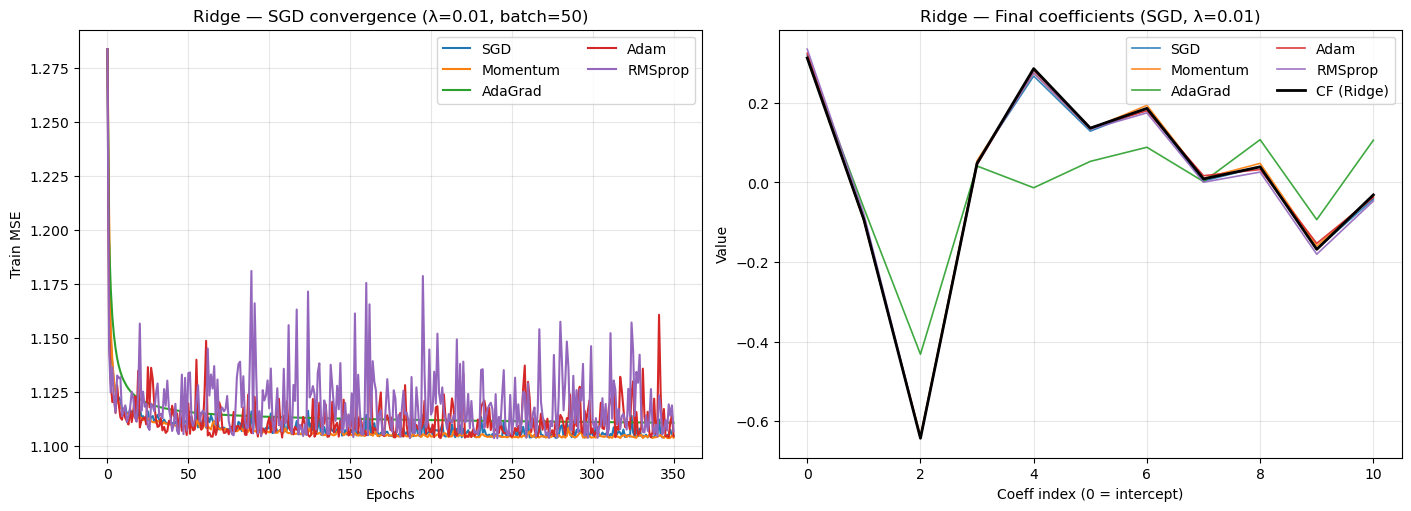

In [19]:
# ===== Ridge (z-score features; intercept not penalized) ======================

# Z-score features using TRAIN stats; THEN add intercept
Xz_tr_t, Xz_te_t, mu_z, sd_z = standardize(X_tr_raw, X_te_raw, mode="zscore")
Xz_tr = add_intercept(Xz_tr_t)
Xz_te = add_intercept(Xz_te_t)

# Sanity checks
assert np.allclose(Xz_tr[:,0], 1.0) and np.allclose(Xz_te[:,0], 1.0), "Intercept must be 1s."

# Safe step size for Ridge on THIS design
eta_ridge = eta_safe_from_hessian(Xz_tr, lam=LAM)

# Ridge gradients (full + minibatch) — intercept not penalized
ridge_full = ridge_grad_full_builder(Xz_tr, y_tr, LAM, intercept_free=True)
def ridge_mb(theta, Xb, yb):
    return ridge_grad_minibatch(theta, Xb, yb, LAM, intercept_free=True)

# Learning rates
lr_fb  = LR_FULL * eta_ridge
lr_sgd = LR_SGD  * eta_ridge

# Train families
fb_ridge = train_full_batch_family(ridge_full, Xz_tr, y_tr, lr=lr_fb,  iters=ITERS)
mb_ridge = train_sgd_family(ridge_mb,        Xz_tr, y_tr, lr=lr_sgd, epochs=ITERS, batch_size=BATCH, seed=SEED)

# Closed form Ridge on the same z-scored design
theta_cf_ridge = ridge_closed_form(Xz_tr, y_tr, LAM)

# Convergence & plots (use Xz_tr)
conv_fb_ridge = {k: train_mse_over_traj(Xz_tr, y_tr, traj, mse) for k, (_, traj) in fb_ridge.items()}
conv_mb_ridge = {k: train_mse_over_traj(Xz_tr, y_tr, traj, mse) for k, (_, traj) in mb_ridge.items()}

fig, axes = plt.subplots(1, 2, figsize=(14,5), constrained_layout=True)
plot_convergence(axes[0], conv_fb_ridge, f"Ridge — Full-batch convergence (λ={LAM:g})", "Iterations")
plot_final_coeffs_with_cf(axes[1], fb_ridge, theta_cf_ridge, f"Ridge — Final coefficients (Full-batch, λ={LAM:g})", cf_label="CF (Ridge)")
plt.savefig("RidgeGD.pdf")
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14,5), constrained_layout=True)
plot_convergence(axes[0], conv_mb_ridge, f"Ridge — SGD convergence (λ={LAM:g}, batch={BATCH})", "Epochs")
plot_final_coeffs_with_cf(axes[1], mb_ridge, theta_cf_ridge, f"Ridge — Final coefficients (SGD, λ={LAM:g})", cf_label="CF (Ridge)")
plt.savefig("RidgeSGD.pdf")
plt.show()

## LASSO: GD vs SGD
Subgradient on the L1 term; intercept is not penalized. We use scikit-LASSO as our “CF” reference.

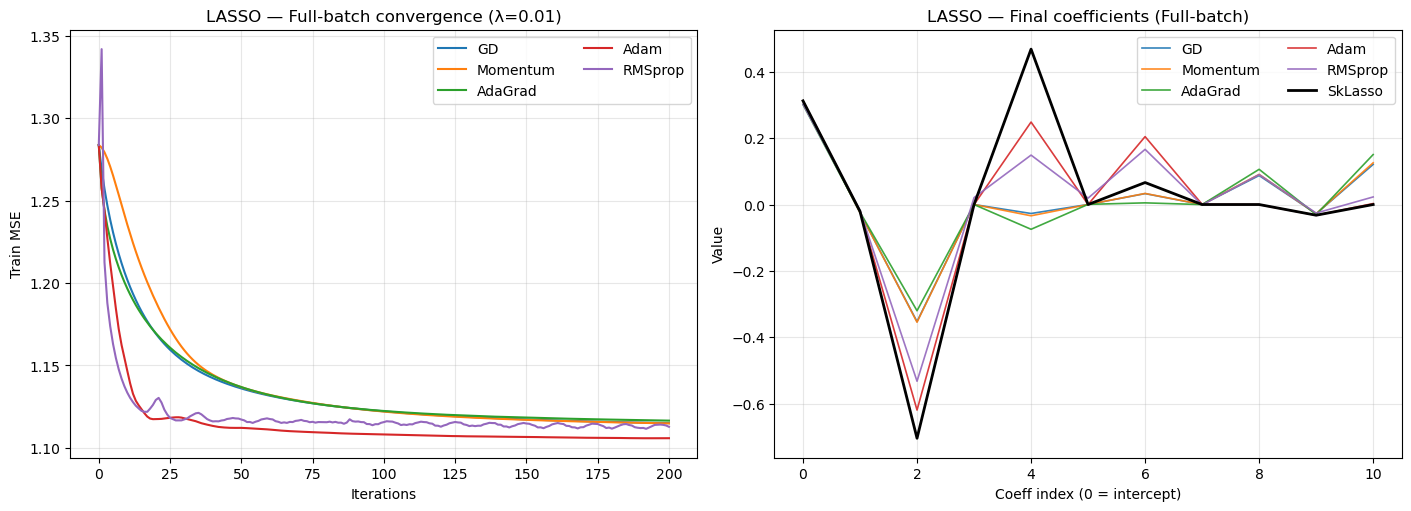

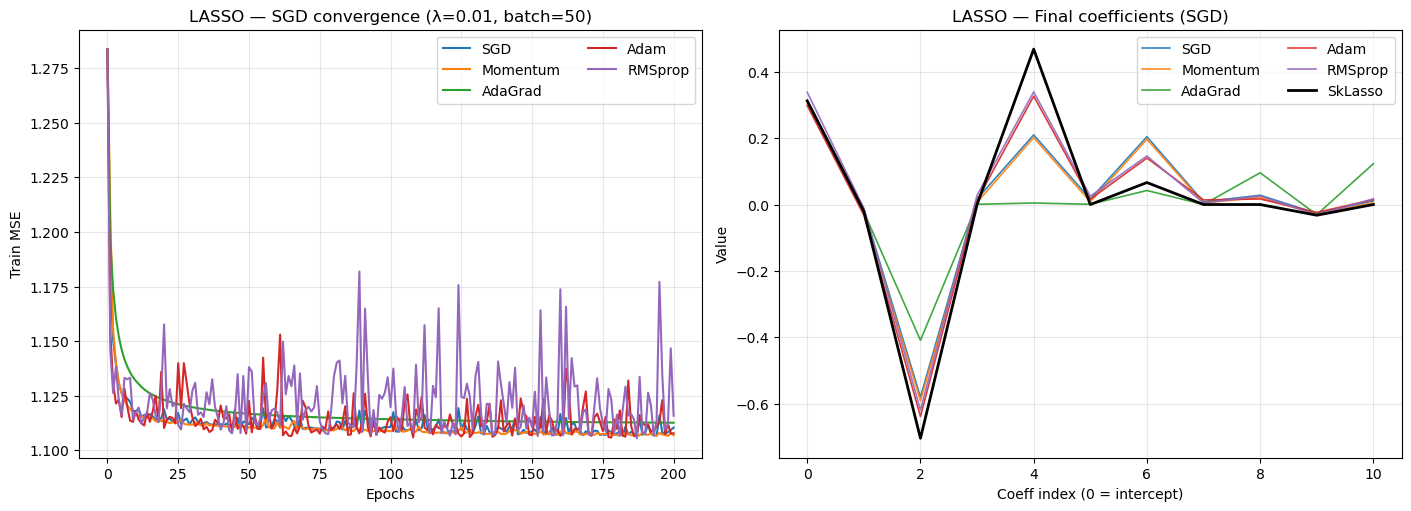

In [28]:
# ===== LASSO (z-score features; intercept not penalized) ======================

# Reuse z-scored design from Ridge cell: Xz_tr, Xz_te
eta_lasso = eta_safe_from_hessian(Xz_tr, lam=LAM)  # conservative but fine

lasso_full = lasso_grad_full_builder(Xz_tr, y_tr, LAM, intercept_free=True)
def lasso_mb(theta, Xb, yb):
    return lasso_grad_minibatch(theta, Xb, yb, LAM, intercept_free=True)

lr_fb  = LR_FULL * eta_lasso
lr_sgd = LR_SGD  * eta_lasso

fb_lasso = train_full_batch_family(lasso_full, Xz_tr, y_tr, lr=lr_fb,  iters=ITERS)
mb_lasso = train_sgd_family(lasso_mb,        Xz_tr, y_tr, lr=lr_sgd, epochs=ITERS, batch_size=BATCH, seed=SEED)

# "CF" for LASSO via scikit-learn (fit_intercept=True on features-only)
from sklearn.linear_model import Lasso as SkLasso
Xtr_no_ic = Xz_tr[:, 1:]           # drop manual intercept
alpha_sklearn = LAM / 2.0          # matches your objective scaling
sk = SkLasso(alpha=alpha_sklearn, fit_intercept=True, max_iter=20_000, tol=1e-7,
             selection='cyclic', random_state=SEED)
sk.fit(Xtr_no_ic, y_tr.ravel())
theta_cf_lasso = np.concatenate(([sk.intercept_], sk.coef_.ravel()))[:, None]

# Convergence & plots (use Xz_tr)
conv_fb_lasso = {k: train_mse_over_traj(Xz_tr, y_tr, traj, mse) for k, (_, traj) in fb_lasso.items()}
conv_mb_lasso = {k: train_mse_over_traj(Xz_tr, y_tr, traj, mse) for k, (_, traj) in mb_lasso.items()}

fig, axes = plt.subplots(1, 2, figsize=(14,5), constrained_layout=True)
plot_convergence(axes[0], conv_fb_lasso, f"LASSO — Full-batch convergence (λ={LAM:g})", "Iterations")
plot_final_coeffs_with_cf(axes[1], fb_lasso, theta_cf_lasso, "LASSO — Final coefficients (Full-batch)", cf_label="SkLasso")
plt.savefig("LassoGD.pdf")
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14,5), constrained_layout=True)
plot_convergence(axes[0], conv_mb_lasso, f"LASSO — SGD convergence (λ={LAM:g}, batch={BATCH})", "Epochs")
plot_final_coeffs_with_cf(axes[1], mb_lasso, theta_cf_lasso, "LASSO — Final coefficients (SGD)", cf_label="SkLasso")
plt.savefig("LassoSGD.pdf")
plt.show()

## Metrics overview
Compact table of Test MSE/R² for all methods (includes CF rows).

In [30]:
# Collect test metrics for all families + CF baselines (OLS, Ridge, LASSO (SkLasso))

def _add_rows(model, regime, fam, Xte, yte, steps, batch=None):
    rows = []
    for name, (th, traj) in fam.items():
        rows.append(dict(Model=model, Regime=regime, Optimizer=name,
                         Steps=steps, Batch=(batch if regime=="SGD" else "-"),
                         Test_MSE=mse(yte, Xte @ th), Test_R2=r2_score(yte, Xte @ th)))
    return rows

def _maybe(rows, model, regime, fam_name, Xte, yte, steps, batch=None):
    if fam_name in globals():
        fam = globals()[fam_name]
        rows += _add_rows(model, regime, fam, Xte, yte, steps, batch)
    return rows

rows = []
# Use matching designs: OLS -> Xc_te ; Ridge/LASSO -> Xz_te
rows = _maybe(rows, "OLS",   "Full", "fb_ols",   Xc_te, y_te, ITERS)
rows = _maybe(rows, "OLS",   "SGD",  "mb_ols",   Xc_te, y_te, ITERS, BATCH)
rows = _maybe(rows, "Ridge", "Full", "fb_ridge", Xz_te, y_te, ITERS)
rows = _maybe(rows, "Ridge", "SGD",  "mb_ridge", Xz_te, y_te, ITERS, BATCH)
rows = _maybe(rows, "LASSO", "Full", "fb_lasso", Xz_te, y_te, ITERS)
rows = _maybe(rows, "LASSO", "SGD",  "mb_lasso", Xz_te, y_te, ITERS, BATCH)

# Baselines (only if they exist)
if "theta_cf_ols" in globals():
    rows.append(dict(Model="OLS",   Regime="CF",        Optimizer="ClosedForm", Steps=0, Batch="-",
                     Test_MSE=mse(y_te, Xc_te @ theta_cf_ols),   Test_R2=r2_score(y_te, Xc_te @ theta_cf_ols)))
if "theta_cf_ridge" in globals():
    rows.append(dict(Model="Ridge", Regime="CF",        Optimizer="ClosedForm", Steps=0, Batch="-",
                     Test_MSE=mse(y_te, Xz_te @ theta_cf_ridge), Test_R2=r2_score(y_te, Xz_te @ theta_cf_ridge)))
if "theta_cf_lasso" in globals():
    rows.append(dict(Model="LASSO", Regime="Reference", Optimizer="SkLasso", Steps=0, Batch="-",
                     Test_MSE=mse(y_te, Xz_te @ theta_cf_lasso), Test_R2=r2_score(y_te, Xz_te @ theta_cf_lasso)))

import pandas as pd
df = pd.DataFrame(rows) if rows else pd.DataFrame(columns=["Model","Regime","Optimizer","Steps","Batch","Test_MSE","Test_R2"])
reg_order = pd.CategoricalDtype(categories=["CF", "Reference", "Full", "SGD"], ordered=True)
if not df.empty:
    df["Regime"] = df["Regime"].astype(reg_order)
    df = df.sort_values(["Model", "Regime", "Test_MSE"], ascending=[True, True, True])

print("Test metrics after training")
display(df.round({"Test_MSE":6, "Test_R2":6}))

Test metrics after training


,Model,Regime,Optimizer,Steps,Batch,Test_MSE,Test_R2
32,LASSO,Reference,SkLasso,0,-,1.127942,0.044089
23,LASSO,Full,Adam,200,-,1.131100,0.041413
24,LASSO,Full,RMSprop,200,-,1.133659,0.039244
20,LASSO,Full,GD,200,-,1.143927,0.030542
21,LASSO,Full,Momentum,200,-,1.144218,0.030295
22,LASSO,Full,AdaGrad,200,-,1.145432,0.029266
28,LASSO,SGD,Adam,200,50,1.132759,0.040007
29,LASSO,SGD,RMSprop,200,50,1.133994,0.038960
25,LASSO,SGD,SGD,200,50,1.134225,0.038764
26,LASSO,SGD,Momentum,200,50,1.134616,0.038433


## Best SGD fits
Overlay best SGD fits per model with the ground-truth curve and data points.

,Model,Variant,MSE,R2
0,OLS,Best SGD (Adam),1.147961,0.027124
1,OLS,CF,1.109688,0.059559
2,Ridge,Best SGD (Momentum),1.125451,0.046200
3,Ridge,CF,1.124962,0.046615
4,LASSO,Best SGD (RMSprop),1.133994,0.038960
5,LASSO,CF (SkLasso),1.127942,0.044089


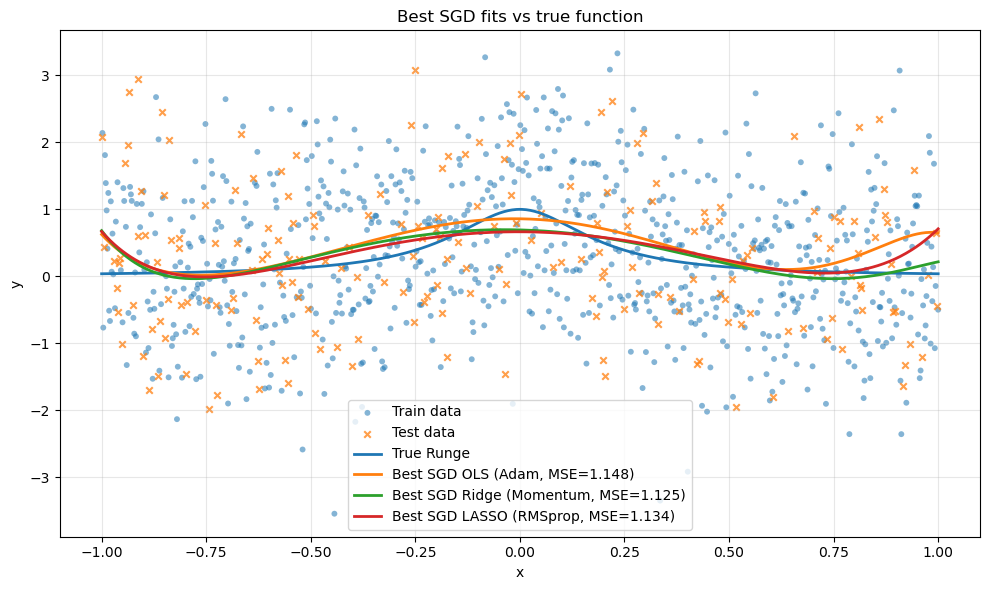

Best SGD OLS   : Adam   max|Δθ| to CF = 8.576e+01
Best SGD Ridge : Momentum max|Δθ| to CF = 1.067e-02
Best SGD LASSO : RMSprop max|Δθ| to CF = 1.289e-01


In [31]:
# Best-SGD vs CF comparisons + smooth grid predictions

# Make sure the needed designs/stats exist
assert "mu_c" in globals() and "sd_c" in globals() and "Xc_te" in globals(), "Run the OLS cell first."
assert "mu_z" in globals() and "sd_z" in globals() and "Xz_te" in globals(), "Run the Ridge cell first."

def _best_vs_cf(mb_dict, theta_cf):
    best = None
    for name, (th, traj) in mb_dict.items():
        d = max_abs_diff(th, theta_cf)
        if best is None or d < best[2]:
            best = (name, th, d)
    return best  # (name, theta, diff)

best_ols   = _best_vs_cf(mb_ols,   theta_cf_ols)   if "mb_ols"   in globals() and "theta_cf_ols"   in globals() else None
best_ridge = _best_vs_cf(mb_ridge, theta_cf_ridge) if "mb_ridge" in globals() and "theta_cf_ridge" in globals() else None
best_lasso = _best_vs_cf(mb_lasso, theta_cf_lasso) if "mb_lasso" in globals() and "theta_cf_lasso" in globals() else None

# Dense grid (use correct stats per model)
xs = np.linspace(-1, 1, 600)
from mlmods.data_utils import polynomial_features, add_intercept, runge

Xg_raw = polynomial_features(xs, DEGREE, intercept=False)
Xgc = add_intercept((Xg_raw - mu_c) / sd_c)  # center-only: sd_c == 1s (safe)
Xgz = add_intercept((Xg_raw - mu_z) / sd_z)  # z-score

y_true = runge(xs)
yhat_ols   = (Xgc @ best_ols[1]).ravel()   if best_ols   else None
yhat_ridge = (Xgz @ best_ridge[1]).ravel() if best_ridge else None
yhat_lasso = (Xgz @ best_lasso[1]).ravel() if best_lasso else None

# Compute test MSEs on matching TEST designs
mse_ols   = mse(y_te, Xc_te @ best_ols[1])   if best_ols   else None
mse_ridge = mse(y_te, Xz_te @ best_ridge[1]) if best_ridge else None
mse_lasso = mse(y_te, Xz_te @ best_lasso[1]) if best_lasso else None

# Summarize (only rows that exist)
rows = []
if best_ols:
    rows.append(dict(Model="OLS",   Variant=f"Best SGD ({best_ols[0]})",   MSE=mse_ols,   R2=r2_score(y_te, Xc_te @ best_ols[1])))
    rows.append(dict(Model="OLS",   Variant="CF",                          MSE=mse(y_te, Xc_te @ theta_cf_ols),   R2=r2_score(y_te, Xc_te @ theta_cf_ols)))
if best_ridge:
    rows.append(dict(Model="Ridge", Variant=f"Best SGD ({best_ridge[0]})", MSE=mse_ridge, R2=r2_score(y_te, Xz_te @ best_ridge[1])))
    rows.append(dict(Model="Ridge", Variant="CF",                          MSE=mse(y_te, Xz_te @ theta_cf_ridge), R2=r2_score(y_te, Xz_te @ theta_cf_ridge)))
if best_lasso:
    rows.append(dict(Model="LASSO", Variant=f"Best SGD ({best_lasso[0]})", MSE=mse_lasso, R2=r2_score(y_te, Xz_te @ best_lasso[1])))
    rows.append(dict(Model="LASSO", Variant="CF (SkLasso)",                MSE=mse(y_te, Xz_te @ theta_cf_lasso), R2=r2_score(y_te, Xz_te @ theta_cf_lasso)))

summary = pd.DataFrame(rows).round(6) if rows else pd.DataFrame(columns=["Model","Variant","MSE","R2"])
display(summary)

# Plot (draw only what exists)
plt.figure(figsize=(10,6))
x_tr = X_tr_raw[:,0]; x_te = X_te_raw[:,0]
plt.scatter(x_tr, y_tr, s=18, alpha=0.55, label="Train data", edgecolor='none')
plt.scatter(x_te, y_te, s=22, alpha=0.75, label="Test data", marker='x')
plt.plot(xs, y_true, linewidth=2.0, label="True Runge")

if best_ols:
    plt.plot(xs, yhat_ols,   linewidth=2.0, label=f"Best SGD OLS ({best_ols[0]}, MSE={mse_ols:.3f})")
if best_ridge:
    plt.plot(xs, yhat_ridge, linewidth=2.0, label=f"Best SGD Ridge ({best_ridge[0]}, MSE={mse_ridge:.3f})")
if best_lasso:
    plt.plot(xs, yhat_lasso, linewidth=2.0, label=f"Best SGD LASSO ({best_lasso[0]}, MSE={mse_lasso:.3f})")

plt.title("Best SGD fits vs true function")
plt.xlabel("x"); plt.ylabel("y")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

if best_ols:   print(f"Best SGD OLS   : {best_ols[0]}   max|Δθ| to CF = {best_ols[2]:.3e}")
if best_ridge: print(f"Best SGD Ridge : {best_ridge[0]} max|Δθ| to CF = {best_ridge[2]:.3e}")
if best_lasso: print(f"Best SGD LASSO : {best_lasso[0]} max|Δθ| to CF = {best_lasso[2]:.3e}")